In [1]:
import requests
from config import API_KEY
import pandas as pd
import numpy as np

## Get Data from eia API

In [2]:
url = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.EMM_EPMRR_PTE_YORD_DPG.W"

In [3]:
df = pd.DataFrame(requests.get(url).json()['series'][0]['data'])

In [4]:
df.rename(columns = {0:"week", 1:"price"}, inplace = True)

In [5]:
pd.to_datetime(df['week'])

0      2020-11-09
1      2020-11-02
2      2020-10-26
3      2020-10-19
4      2020-10-12
          ...    
1062   2000-07-03
1063   2000-06-26
1064   2000-06-19
1065   2000-06-12
1066   2000-06-05
Name: week, Length: 1067, dtype: datetime64[ns]

In [6]:
df['week'] = pd.to_datetime(df['week'])

<AxesSubplot:xlabel='week'>

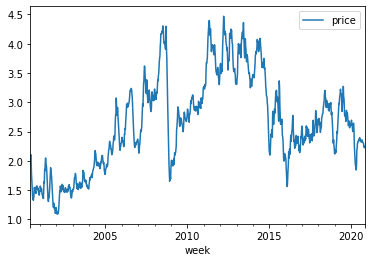

In [7]:
df.plot(x = 'week', y = 'price')

In [8]:
df['price'].diff()

0         NaN
1      -0.014
2       0.026
3      -0.016
4       0.034
        ...  
1062    0.098
1063    0.203
1064    0.119
1065   -0.017
1066   -0.142
Name: price, Length: 1067, dtype: float64

In [9]:
df['change'] = df['price'].diff()

In [10]:
df.dropna(inplace =True)

<AxesSubplot:xlabel='week'>

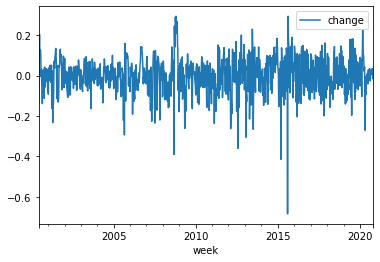

In [11]:
df.plot(x = 'week', y='change')

## Processs the data

In [12]:
#train test split
train_size = int(0.8 * len(df))
df_train = df.iloc[0:train_size]
df_test = df.iloc[train_size:]

In [13]:
df_train

,week,price,change
1,2020-11-02,2.223,-0.014
2,2020-10-26,2.249,0.026
3,2020-10-19,2.233,-0.016
4,2020-10-12,2.267,0.034
5,2020-10-05,2.301,0.034
...,...,...,...
848,2004-08-09,1.932,-0.021
849,2004-08-02,1.912,-0.020
850,2004-07-26,1.937,0.025
851,2004-07-19,1.980,0.043


In [14]:
df_test

,week,price,change
853,2004-07-05,1.918,-0.027
854,2004-06-28,1.936,0.018
855,2004-06-21,1.951,0.015
856,2004-06-14,2.027,0.076
857,2004-06-07,2.109,0.082
...,...,...,...
1062,2000-07-03,1.786,0.098
1063,2000-06-26,1.989,0.203
1064,2000-06-19,2.108,0.119
1065,2000-06-12,2.091,-0.017


In [15]:
#function for making windows
def make_windows(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [16]:
time_steps = 10
X_train, y_train = make_windows(df_train[['change']], df_train['change'], time_steps)
X_test, y_test = make_windows(df_test[['change']], df_test['change'], time_steps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(842, 10, 1) (842,) (204, 10, 1) (204,)


## Build Model

In [17]:
from tensorflow import keras

C:\Users\mpira\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mpira\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mpira\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mpira\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [18]:
model = keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    keras.layers.LSTM(units = 64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    keras.layers.LSTM(units = 32, input_shape=(X_train.shape[1], 64), return_sequences=False),
    # Shape => [batch, time, features]
    keras.layers.Dense(units=1)
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

In [20]:
history = model.fit(
    X_train, y_train,
    epochs=25,
    verbose=1,
    shuffle=False
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/25
842/842 [==============================] - 1s 1ms/sample - loss: 0.0092
Epoch 2/25
842/842 [==============================] - 0s 340us/sample - loss: 0.0090
Epoch 3/25
842/842 [==============================] - 0s 330us/sample - loss: 0.0089
Epoch 4/25
842/842 [==============================] - 0s 330us/sample - loss: 0.0088
Epoch 5/25
842/842 [==============================] - 0s 334us/sample - loss: 0.0088
Epoch 6/25
842/842 [==============================] - 0s 354us/sample - loss: 0.0088
Epoch 7/25
842/842 [==============================] - 0s 339us/sample - loss: 0.0087
Epoch 8/25
842/842 [==============================] - 0s 340us/sample - loss: 0.0087
Epoch 9/25
842/842 [==============================] - 0s 346us/sample - loss: 0.0086
Epoch 10/25
842/842 [==============================] - 0s 356us/sample - loss: 0.0086
Epoch 11/25
842/842 [==============================] - 0s

In [21]:
y_pred = model.predict(X_test)

In [22]:
import matplotlib.pyplot as plt

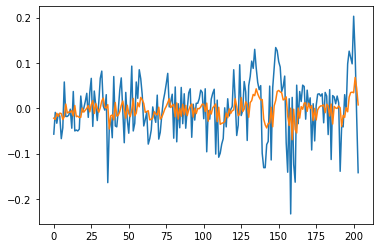

In [23]:
fig, ax = plt.subplots()
ax.plot(y_test)
ax.plot(y_pred)

In [24]:
y_err = np.abs(y_test.reshape(204 ,1) - y_pred)

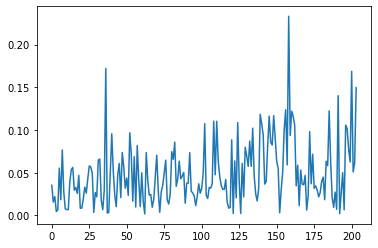

In [25]:
plt.plot(y_err)

In [26]:
np.sum(y_err[0:4])

0.07735294851660712

In [27]:
df_test

,week,price,change
853,2004-07-05,1.918,-0.027
854,2004-06-28,1.936,0.018
855,2004-06-21,1.951,0.015
856,2004-06-14,2.027,0.076
857,2004-06-07,2.109,0.082
...,...,...,...
1062,2000-07-03,1.786,0.098
1063,2000-06-26,1.989,0.203
1064,2000-06-19,2.108,0.119
1065,2000-06-12,2.091,-0.017


In [28]:
df_test['price'].iloc[0]

1.918

In [29]:
price_pred = [ 1.918 + np.sum(y_pred[1:n]) for n in range(1,len(df_test)) ]

In [30]:
price_pred

[1.918,
 1.893336756557226,
 1.8822695225775241,
 1.8647042684555053,
 1.8539687715768813,
 1.8423387058377265,
 1.8176785059571265,
 1.7990083717107772,
 1.808341207385063,
 1.7979072578549384,
 1.7896419488191604,
 1.7808941178321838,
 1.775938826084137,
 1.7592612676620483,
 1.7654000245332717,
 1.7469070576429366,
 1.7296255551576614,
 1.7093228571414947,
 1.689510750055313,
 1.6898999683856963,
 1.681415589928627,
 1.6771424584388732,
 1.6771161727905273,
 1.6832484774589538,
 1.6754009001255035,
 1.6835000388622283,
 1.7002473049163818,
 1.6887931846380233,
 1.6992338471412658,
 1.6990161858797073,
 1.6903608165979385,
 1.6915341936349868,
 1.707544254541397,
 1.7301003210544585,
 1.7327304356098174,
 1.7329945437908172,
 1.7410240941047668,
 1.6953015797138213,
 1.6787973217964172,
 1.6640097670555114,
 1.638450848340988,
 1.6511727147102355,
 1.6339267663955688,
 1.6186852328777313,
 1.611368911743164,
 1.6175209157466888,
 1.6334118716716766,
 1.6309925787448882,
 1.6092182569

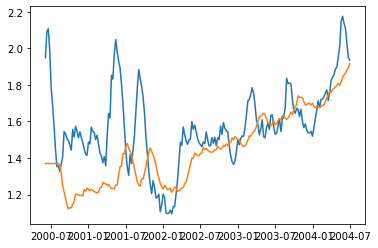

In [31]:
fig, ax = plt.subplots()
ax.plot(df_test['week'].iloc[1:],df_test['price'].iloc[1:])
ax.plot(df_test['week'].iloc[1:], price_pred[:214])